In [1]:
# Step 1: Install the Kaggle library
!pip install -q kaggle

In [2]:

# Step 2: Upload the kaggle.json file (This will prompt you to choose your file)
from google.colab import files
files.upload()

# Step 3: Move kaggle.json to the proper directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Step 4: Set permissions for the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

# Step 5: Download the dataset
# This is the specific dataset URL and ID you provided from Kaggle
!kaggle datasets download -d surajghuwalewala/ham1000-segmentation-and-classification

# Step 6: Unzip the downloaded dataset
!unzip ham1000-segmentation-and-classification.zip -d ./ham1000_data

Streaming output truncated to the last 5000 lines.
  inflating: ./ham1000_data/masks/ISIC_0029321_segmentation.png  
  inflating: ./ham1000_data/masks/ISIC_0029322_segmentation.png  
  inflating: ./ham1000_data/masks/ISIC_0029323_segmentation.png  
  inflating: ./ham1000_data/masks/ISIC_0029324_segmentation.png  
  inflating: ./ham1000_data/masks/ISIC_0029325_segmentation.png  
  inflating: ./ham1000_data/masks/ISIC_0029326_segmentation.png  
  inflating: ./ham1000_data/masks/ISIC_0029327_segmentation.png  
  inflating: ./ham1000_data/masks/ISIC_0029328_segmentation.png  
  inflating: ./ham1000_data/masks/ISIC_0029329_segmentation.png  
  inflating: ./ham1000_data/masks/ISIC_0029330_segmentation.png  
  inflating: ./ham1000_data/masks/ISIC_0029331_segmentation.png  
  inflating: ./ham1000_data/masks/ISIC_0029332_segmentation.png  
  inflating: ./ham1000_data/masks/ISIC_0029333_segmentation.png  
  inflating: ./ham1000_data/masks/ISIC_0029334_segmentation.png  
  inflating: ./ham1000_da

In [ ]:



# Verify the contents
import os
os.listdir('./ham1000_data')


In [3]:
import pandas as pd

df = pd.read_csv('/content/ham1000_data/GroundTruth.csv')
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
import os
import shutil
import pandas as pd

# Load the ground truth data
df = pd.read_csv('/content/ham1000_data/GroundTruth.csv')

# Define paths
source_folder = '/content/ham1000_data/images'
destination_folder = '/content/ham1000_data/classified_images'

# Create destination folders for each class
classes = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
for class_name in classes:
    os.makedirs(os.path.join(destination_folder, class_name), exist_ok=True)

# Iterate over each row in the dataframe and move files based on class labels
for index, row in df.iterrows():
    # Get image name and class labels
    image_name = row['image'] + '.jpg'
    image_path = os.path.join(source_folder, image_name)

    # Move image to the corresponding class folder based on label
    for class_name in classes:
        if row[class_name] == 1.0:  # If the label is 1 for the class
            dest_path = os.path.join(destination_folder, class_name, image_name)
            shutil.copy(image_path, dest_path)  # Copy image to the respective folder

print("Images have been separated into respective class folders.")


Images have been separated into respective class folders.


<ipython-input-5-61e9dfdadf82>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='Image Count', data=class_counts_df, palette="viridis")


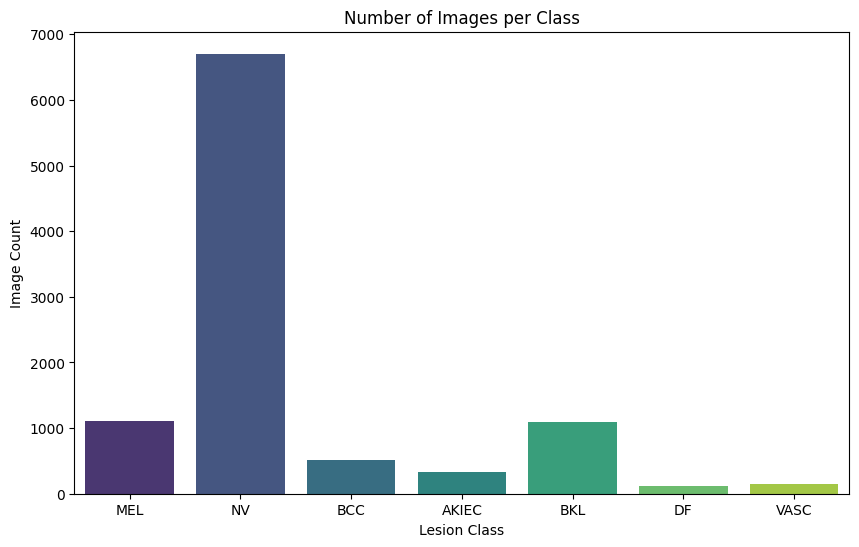

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the ground truth data
df = pd.read_csv('/content/ham1000_data/GroundTruth.csv')

# Count the number of images per class
class_counts = df.iloc[:, 1:].sum()  # Summing each column to get the count of each class

# Convert to DataFrame for easier plotting
class_counts_df = class_counts.reset_index()
class_counts_df.columns = ['Class', 'Image Count']

# Plot the count plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Class', y='Image Count', data=class_counts_df, palette="viridis")
plt.title('Number of Images per Class')
plt.xlabel('Lesion Class')
plt.ylabel('Image Count')
plt.show()


In [6]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [7]:
# Load ground truth CSV
df = pd.read_csv('/content/ham1000_data/GroundTruth.csv')

# Add column 'class' for the target label
df['class'] = df.iloc[:, 1:].idxmax(axis=1)

# Split into train and test data
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)


In [10]:
# Define data generators for training and testing
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Set image directory path
image_dir = '/content/ham1000_data/classified_images'

# Flow images from directory using data generator
train_generator = train_datagen.flow_from_dataframe(
    train_df, directory=image_dir, x_col='image', y_col='class',
    target_size=(128, 128), batch_size=32, class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
    test_df, directory=image_dir, x_col='image', y_col='class',
    target_size=(128, 128), batch_size=32, class_mode='categorical')


Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 8012 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2003 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


In [11]:
# Load ground truth CSV
df = pd.read_csv('/content/ham1000_data/GroundTruth.csv')

# Step 1: Update the 'image' column to contain the full path to each image
df['image'] = '/content/ham1000_data/images/' + df['image'] + '.jpg'  # <-- Update the path here if necessary

# Add column 'class' for the target label by selecting the column with the highest value
df['class'] = df.iloc[:, 1:-1].idxmax(axis=1)  # Assuming class labels start from column 1 to the second-last column

# Check if paths are valid (for debugging)
print(df['image'].head())  # Print first few paths to check format
print(all([os.path.exists(path) for path in df['image']]))  # Check if paths are valid

# Step 2: Split into train and test data based on the 'class' column
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)

# Step 3: Set up ImageDataGenerators for training and testing
train_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="image",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)


0    /content/ham1000_data/images/ISIC_0024306.jpg
1    /content/ham1000_data/images/ISIC_0024307.jpg
2    /content/ham1000_data/images/ISIC_0024308.jpg
3    /content/ham1000_data/images/ISIC_0024309.jpg
4    /content/ham1000_data/images/ISIC_0024310.jpg
Name: image, dtype: object
True
Found 8012 validated image filenames belonging to 6 classes.
Found 2003 validated image filenames belonging to 6 classes.


In [13]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score

In [14]:

# Step 4: Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(df['class'].unique()), activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Step 5: Train the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10
)

# Step 6: Evaluate the model
# Predict on test data
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = predictions.argmax(axis=-1)
true_classes = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Print classification report
class_labels = list(test_generator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


251/251 ━━━━━━━━━━━━━━━━━━━━ 1092s 4s/step - accuracy: 0.6549 - loss: 1.1610 - val_accuracy: 0.6685 - val_loss: 0.9312
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1089s 4s/step - accuracy: 0.6878 - loss: 0.8562 - val_accuracy: 0.6875 - val_loss: 0.8312
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1132s 4s/step - accuracy: 0.6856 - loss: 0.8380 - val_accuracy: 0.6985 - val_loss: 0.8068
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1097s 4s/step - accuracy: 0.7156 - loss: 0.7629 - val_accuracy: 0.7134 - val_loss: 0.7549
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1079s 4s/step - accuracy: 0.7192 - loss: 0.7305 - val_accuracy: 0.7059 - val_loss: 0.7585
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1085s 4s/step - accuracy: 0.7425 - loss: 0.6919 - val_accuracy: 0.7019 - val_loss: 0.8193
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1108s 4s/step - accuracy: 0.7456 - loss: 0.6810 - val_accuracy: 0.7259 - val_loss: 0.7518
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1093s 4s/step - accuracy: 0.7924 - loss: 0.5693 - val_accurac